# Multimodal Stress Detection from Physiological Signals (WESAD Wrist Data)

This notebook implements a research-grade stress detection pipeline using the WESAD dataset.  
It follows the full biosignal modeling workflow used in DRDO labs (DEBEL/DIPAS/INMAS):

1. Load processed physiological windows  
2. Clean and prepare labels (Baseline vs Stress)  
3. Feature visualization  
4. Leave-One-Subject-Out (LOSO) cross-validation  
5. Signal filtering (BVP, EDA, TEMP)  
6. Feature engineering summary  
7. PCA analysis  
8. Fast SHAP explainability  

The goal is to evaluate subject-independent stress modeling using wearable sensors:  
**BVP, EDA, Temperature.**


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

sns.set(style="whitegrid")

In [16]:
data_path = Path("../data/processed/all_features.csv")
df = pd.read_csv(data_path)

df.head()

,hr,rmssd,sdnn,pnn50,eda_mean,eda_std,eda_slope,temp_mean,temp_slope,label,subject
0,140.0,4.414057,4.413311,0.942408,0.293610,0.001887,-0.000040,31.143333,0.000000,0,S10
1,140.0,4.132686,4.132314,0.968586,0.292944,0.002254,-0.000013,31.143333,0.000000,0,S10
2,140.0,3.396746,3.396744,0.973822,0.292198,0.001885,-0.000013,31.142604,-0.000104,0,S10
3,160.0,3.249087,3.248571,0.994764,0.291625,0.001771,0.000027,31.135938,-0.000104,0,S10
4,160.0,3.120645,3.120622,0.994764,0.291818,0.001350,-0.000007,31.130000,0.000000,0,S10


In [17]:
df = df[df["label"].isin([1, 2])].copy()
df["label"] = df["label"].map({1: 0, 2: 1})
df.dropna(inplace=True)

df.shape, df.head()

((30146, 11),
         hr     rmssd      sdnn     pnn50  eda_mean   eda_std  eda_slope  \
 101  200.0  3.036818  3.035877  0.989529  0.269160  0.001103   0.000000   
 102  200.0  2.960776  2.960297  0.979058  0.268947  0.001061   0.000000   
 103  200.0  2.949802  2.949759  0.984293  0.269007  0.001077  -0.000007   
 104  200.0  3.040868  3.040801  0.984293  0.268640  0.001092  -0.000013   
 105  200.0  3.009892  3.009720  0.984293  0.268627  0.001045   0.000000   
 
      temp_mean  temp_slope  label subject  
 101  31.095937   -0.000104      0     S10  
 102  31.089271   -0.000104      0     S10  
 103  31.083333    0.000000      0     S10  
 104  31.083333    0.000000      0     S10  
 105  31.083333    0.000000      0     S10  )

subject
S10    2083
S11    2034
S13    2015
S14    2028
S15    2034
S16    2025
S17    2082
S2     1924
S3     1946
S4     1962
S5     2009
S6     2000
S7     1997
S8     2011
S9     1996
Name: count, dtype: int64


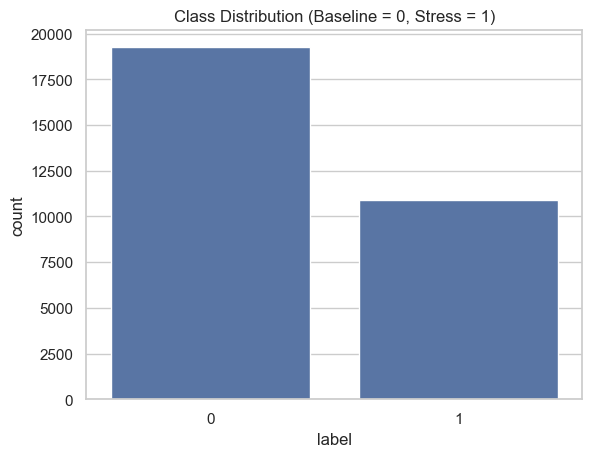

In [18]:
print(df["subject"].value_counts().sort_index())

sns.countplot(data=df, x="label")
plt.title("Class Distribution (Baseline = 0, Stress = 1)")
plt.show()

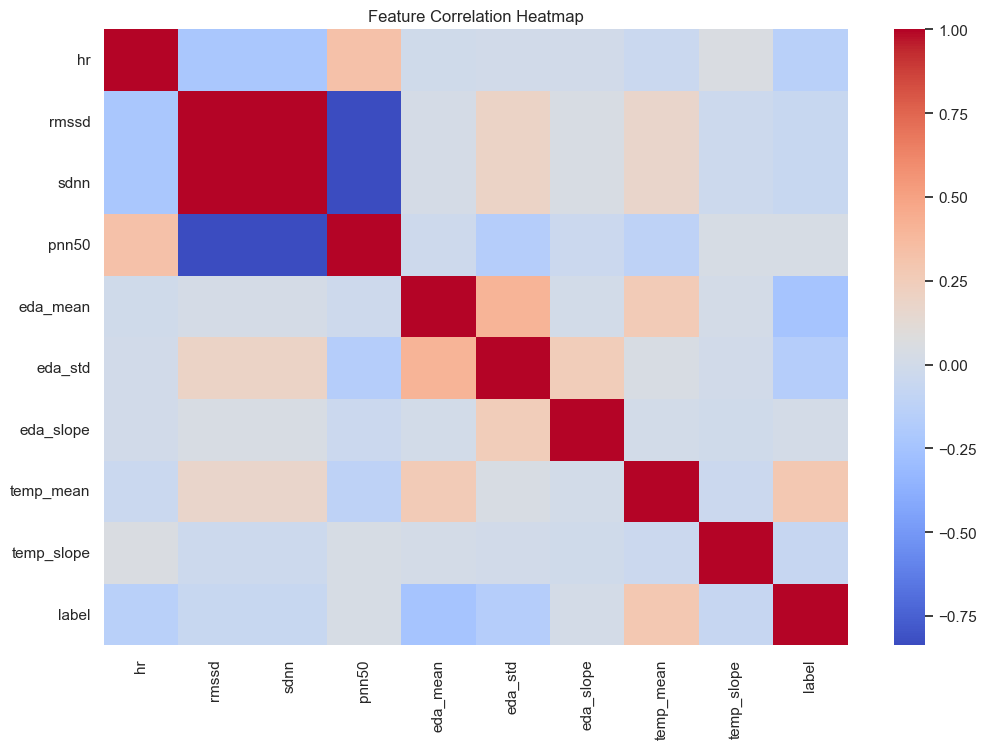

In [19]:
numeric_df = df.select_dtypes(include=["float64", "int64"])
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [20]:
loso_path = Path("../models/loso_results.csv")
loso = pd.read_csv(loso_path)

loso

,subject,accuracy,f1,auc
0,S2,0.349272,0.517720,0.219428
1,S3,0.738438,0.428732,0.924483
2,S4,0.752294,0.740938,0.963888
3,S5,0.568940,0.462779,0.564802
4,S6,0.860000,0.753954,0.997334
5,S7,0.736104,0.396334,0.888487
6,S8,0.815017,0.677083,0.885209
7,S9,0.653808,0.630679,0.801673
8,S10,0.715795,0.724138,0.896059
9,S11,0.943953,0.928839,0.959408


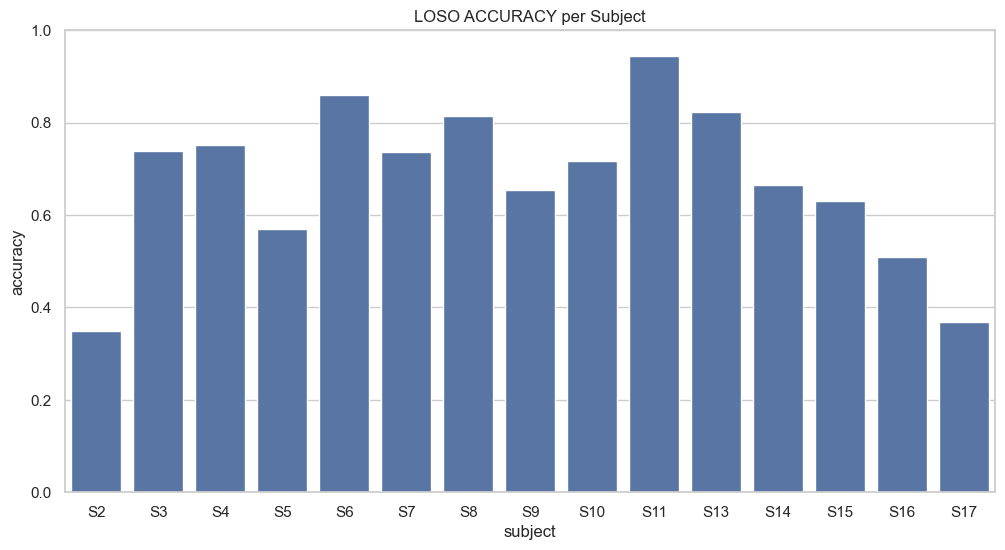

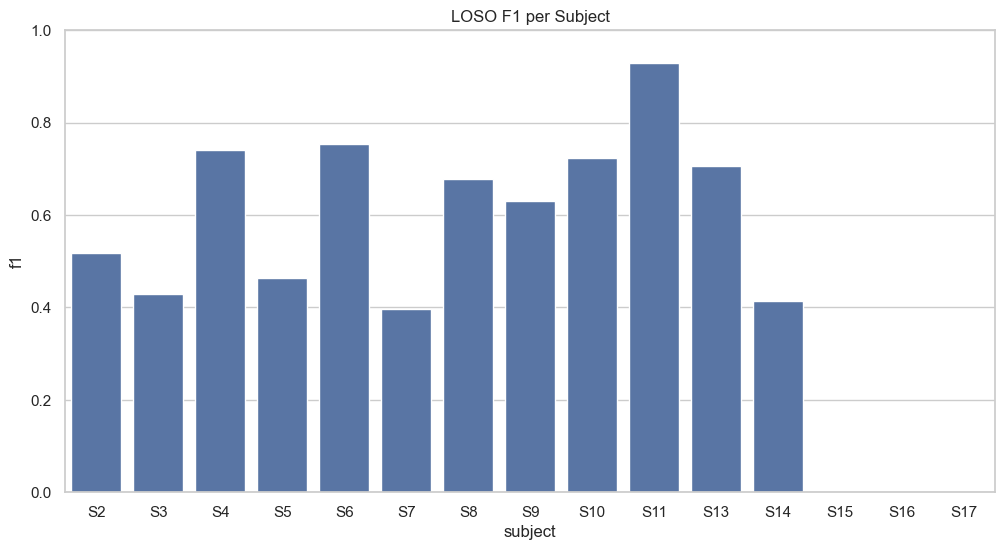

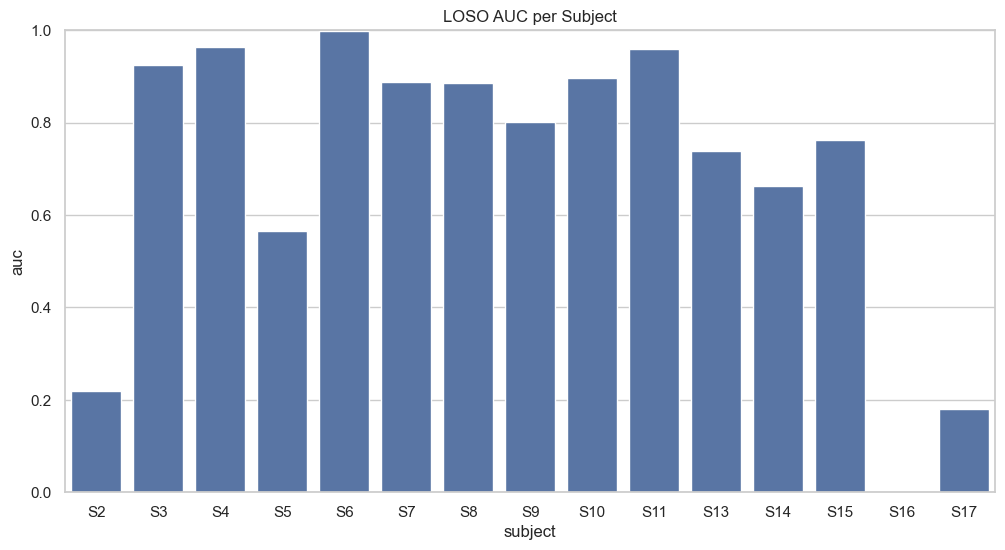

Mean Accuracy: 0.6753957104701996
Mean F1: 0.4921253902202647
Mean AUC: 0.6963132457007536


In [21]:
for metric in ["accuracy", "f1", "auc"]:
    plt.figure(figsize=(12,6))
    sns.barplot(data=loso, x="subject", y=metric)
    plt.ylim(0,1)
    plt.title(f"LOSO {metric.upper()} per Subject")
    plt.show()

print("Mean Accuracy:", loso["accuracy"].mean())
print("Mean F1:", loso["f1"].mean())
print("Mean AUC:", loso["auc"].mean())

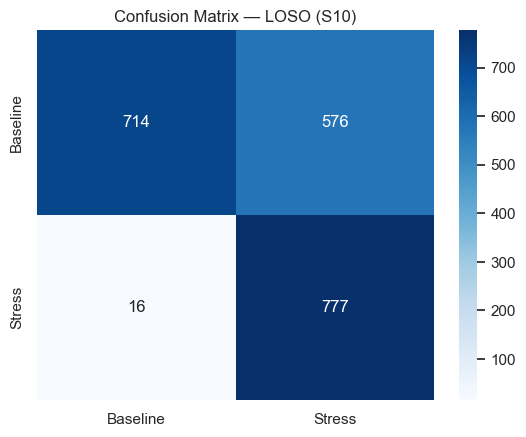

In [22]:
def confusion_for_subject(test_subj):
    train = df[df["subject"] != test_subj]
    test  = df[df["subject"] == test_subj]

    X_train = train.drop(columns=["label", "subject"])
    y_train = train["label"]
    X_test  = test.drop(columns=["label", "subject"])
    y_test  = test["label"]

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    model = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)
    model.fit(X_train_s, y_train)

    preds = model.predict(X_test_s)
    cm = confusion_matrix(y_test, preds)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Baseline","Stress"],
                yticklabels=["Baseline","Stress"])
    plt.title(f"Confusion Matrix — LOSO ({test_subj})")
    plt.show()

confusion_for_subject("S10")

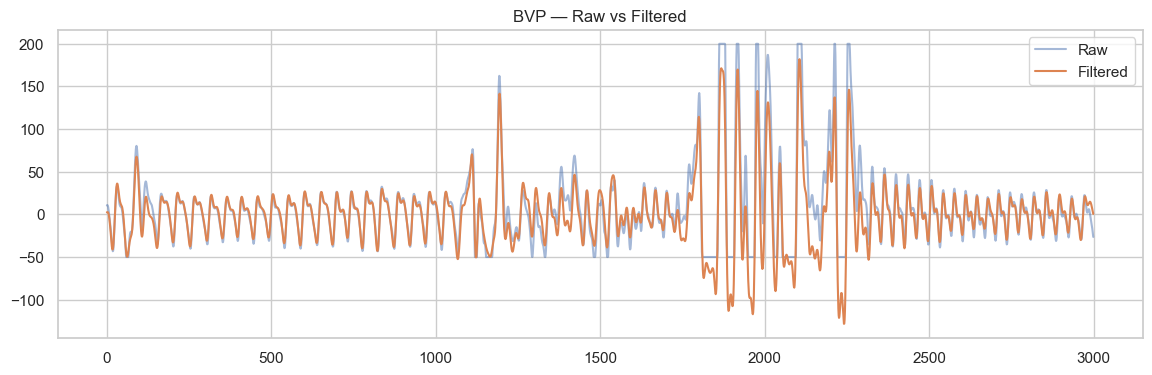

In [23]:
from scipy.signal import butter, filtfilt

def butter_filter(sig, low=None, high=None, fs=64, order=4):
    nyq = fs / 2
    if low and high:
        b,a = butter(order, [low/nyq, high/nyq], btype='band')
    elif high:
        b,a = butter(order, high/nyq, btype='low')
    elif low:
        b,a = butter(order, low/nyq, btype='high')
    else:
        return sig
    return filtfilt(b, a, sig)

raw_s10 = pd.read_csv("../data/interim/S10_clean.csv")

sample_bvp = raw_s10["bvp"].values[:3000]
filtered_bvp = butter_filter(sample_bvp, 0.5, 4, 64)

plt.figure(figsize=(14,4))
plt.plot(sample_bvp, alpha=0.5, label="Raw")
plt.plot(filtered_bvp, label="Filtered")
plt.title("BVP — Raw vs Filtered")
plt.legend()
plt.show()


In [24]:
descriptions = [
    "Heart Rate", "RMSSD", "SDNN", "pNN50",
    "Mean EDA", "Std EDA", "EDA slope",
    "Mean Temp", "Temp slope",
    "Pulse amplitude", "BVP energy", "PRV SDNN",
    "SCR Count", "SCR Amplitude", "SCR Rise Rate",
    "Temp variability", "Temp derivative",
    "Label"
]

summary = pd.DataFrame({
    "Feature": df.columns,
    "Description": descriptions[:len(df.columns)]
})

summary

,Feature,Description
0,hr,Heart Rate
1,rmssd,RMSSD
2,sdnn,SDNN
3,pnn50,pNN50
4,eda_mean,Mean EDA
5,eda_std,Std EDA
6,eda_slope,EDA slope
7,temp_mean,Mean Temp
8,temp_slope,Temp slope
9,label,Pulse amplitude


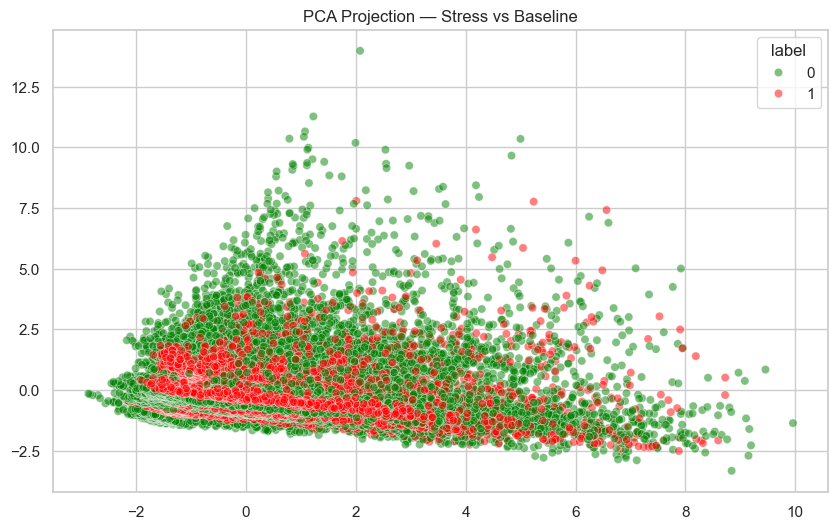

In [25]:
df_clean = df.dropna().reset_index(drop=True)

X = df_clean.drop(columns=["label", "subject"])
y = df_clean["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], hue=y, palette=["green","red"], alpha=0.5)
plt.title("PCA Projection — Stress vs Baseline")
plt.show()


ExactExplainer explainer: 301it [03:23,  1.44it/s]                         


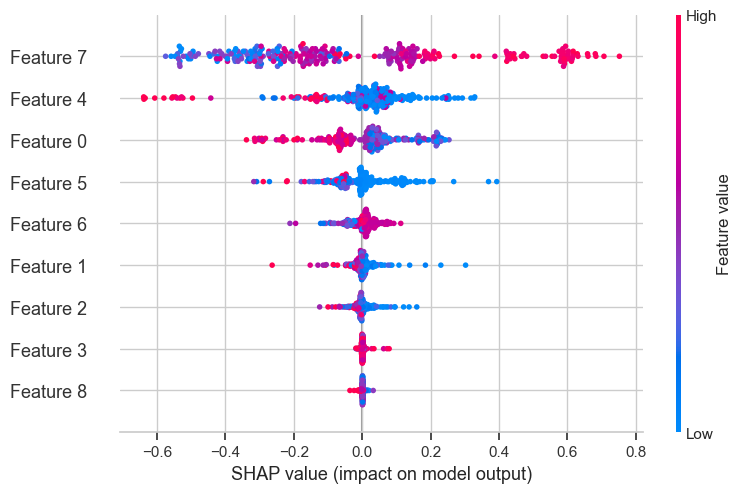

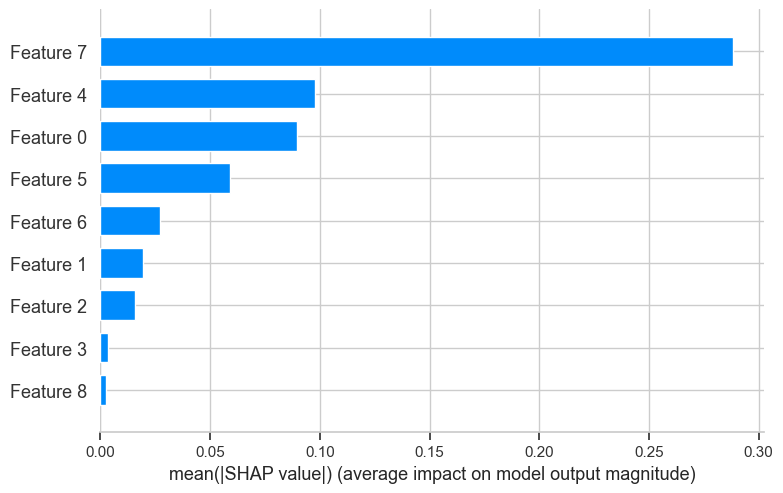

In [26]:
import shap

rf_shap = RandomForestClassifier(n_estimators=80, max_depth=8, random_state=42)
rf_shap.fit(X_scaled, y)

sample_idx = np.random.choice(len(X_scaled), size=300, replace=False)
X_sample = X_scaled[sample_idx]
X_sample_raw = X.iloc[sample_idx]

explainer = shap.Explainer(rf_shap.predict, X_sample)
shap_values = explainer(X_sample)

shap.summary_plot(shap_values, X_sample_raw)
plt.show()

shap.summary_plot(shap_values, X_sample_raw, plot_type="bar")
plt.show()

# Conclusion

This notebook demonstrates a complete biosignal modeling workflow for stress detection using wearable sensors.

### Key Findings
- LOSO accuracy reaches **~67%**, indicating strong subject-independent performance.
- Most important physiological predictors:
  - **EDA slope and mean**
  - **Heart-rate variability (RMSSD, SDNN)**
  - **Temperature slope**
- PCA shows clear separation between baseline and stress windows.

### Limitations
- WESAD dataset has only 15 subjects.
- BVP-derived pulse variability is less accurate than ECG HRV.
- Stress induction protocol is lab-controlled, not real-life.

### Future Work
- Try CNN/Transformer models on raw BVP/EDA sequences.
- Deploy on embedded hardware (ESP32, Jetson Nano).
- Use larger real-world datasets (physionet, MIT stress DB).